In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
# from autocnet.matcher.feature import FlannMatcher

from IPython.display import display

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Generate a 2 image adjacenecy graph

In [2]:
#Point to the adjacency Graph
adjacency = get_path('three_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(extractor_parameters={'nfeatures':500})

In [3]:
%%time
#Match
cg.match()

# Apply outlier detection
cg.apply_func_to_edges(Edge.symmetry_check)
cg.apply_func_to_edges(Edge.ratio_check)
cg.minimum_spanning_tree()

# Compute a homography and apply RANSAC
cg.apply_func_to_edges("compute_fundamental_matrix", clean_keys=['ratio', 'symmetry'])

CPU times: user 30.1 s, sys: 44.5 ms, total: 30.1 s
Wall time: 30.2 s


In [4]:
%%time 
cg.generate_control_network().head()

CPU times: user 5.86 s, sys: 30 ms, total: 5.89 s
Wall time: 5.91 s


,point_id,image_index,keypoint_index,edge,match_idx,x,y,x_off,y_off,corr
measure_id,,,,,,,,,,
0,0,0,202,"(0.0, 1.0)",0,63.392357,791.203735,0,0,inf
1,0,1,0,"(0.0, 1.0)",0,215.773224,740.408081,0,0,inf
2,0,0,316,"(0.0, 1.0)",1,805.988342,147.967743,0,0,inf
3,1,0,373,"(0.0, 1.0)",2,816.339600,639.431213,0,0,inf
4,1,1,1,"(0.0, 1.0)",2,888.853394,583.983337,0,0,inf


### The graph object:
The underlying data structure is a graph, where each node is an image and each edge is the connectivity between nodes.  Nodes and Edges are classes with associated attributes and methods.  This notebook primarily focuses on the plotting functionality on the graph (and graph components).

In these notebooks, the graph object is being stored in the variable `cg`.  Access to nodes and edges is positional.

  * To access a node in the graph:  `cg[node_idx]`, e.g. `cg[0]`.
  * To access an edge in the graph: `cg[source_idx][destination_idx]`, e.g. `cg[0][1]`
  

## Plot the graph

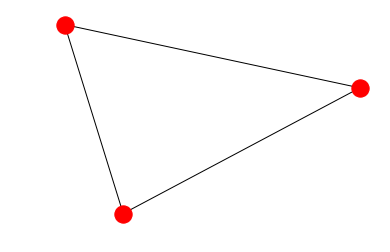

In [5]:
cg.plot()

## Plot features at an individual node, e.g. a single image

All defaults are used here.

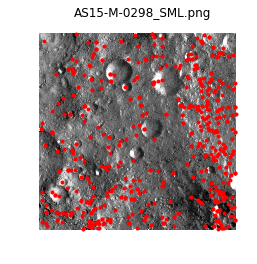

In [6]:
cg.node[1]['data'].plot()

This example specifies a plotting layout, passing in an axis object and passes along a color.  All the MatPlotLib plotting arguments are supported.

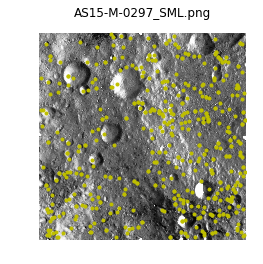

In [7]:
ax1 = plt.subplot(1,1,1)
ax = cg.node[0]['data'].plot(ax=ax1, color='y')

## Plotting Matches on an Edge
The plotting capability on a given node is limited to a single image; one can envision the node as being the image with all associated metadata and derived information.  The edge represents the overlap between images and resultant shared information, e.g. point correspondences, a homography, etc.

#### Plot the matches between an edge using two outlier detector masks
To get a rough idea of what a 'good' results should be, we should see no, or few, lines which intersect.

AxesSubplot(0.125,0.125;0.775x0.755)


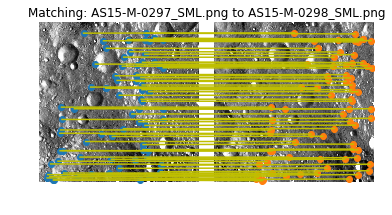

In [8]:
fig, ax = plt.subplots(1,1)
print(ax)
ax = cg[0][1]['data'].plot(clean_keys=['ratio', 'symmetry', 'fundamental'], ax=ax)

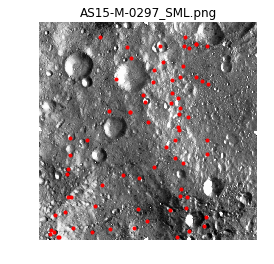

In [9]:
fig, ax = plt.subplots(1,1)
cg[0][1]['data'].plot_source(clean_keys=['ratio', 'symmetry', 'fundamental'], ax=ax)

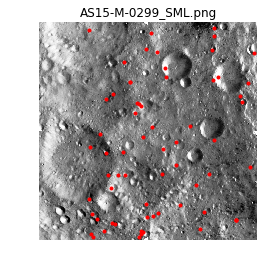

In [10]:
fig, ax = plt.subplots(1,1)
cg[1][2]['data'].plot(node='d', clean_keys=['ratio', 'symmetry', 'fundamental'])

#### Now plot with the added, ransac computed mask

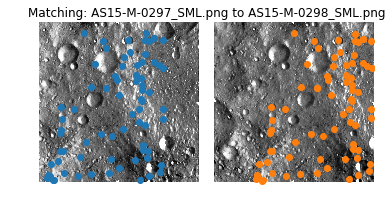

In [11]:
cg[0][1]['data'].plot(clean_keys=['ratio', 'symmetry', 'fundamental'], line_kwargs={'linewidth':0})

## Subpixel Register
We suggest only subpixel registering 'good' candidate matches as the subpixel registration process can be time consuming.

In [12]:
cg[0][1]['data'].subpixel_register(clean_keys=['fundamental', 'symmetry', 'ratio'],template_size=5, search_size=15)

[]

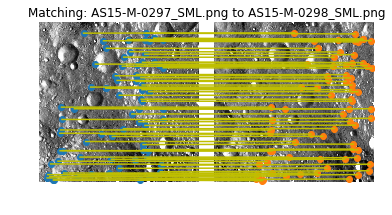

In [13]:
cg[0][1]['data'].plot(clean_keys=['ratio', 'symmetry', 'fundamental', 'subpixel'])

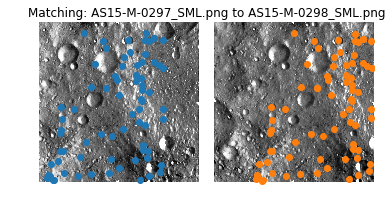

In [14]:
cg[0][1]['data'].plot(clean_keys=['ratio', 'symmetry', 'fundamental', 'subpixel'], line_kwargs={'linewidth':0})

## Apply Suppression vis Disk Covering
This method seeks to keep the $k$ strongest correlations with a good spatial distribution.

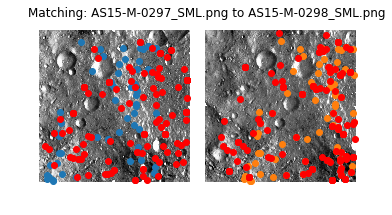

In [15]:
from autocnet.matcher import suppression_funcs as spf
cg[0][1]['data'].suppress(k=100)

# Plot, in blue the points that passed all outlier detectors so far
cg[0][1]['data'].plot(clean_keys=['ratio', 'symmetry', 'fundamental', 'subpixel'], line_kwargs={'linewidth':0})
# Overlay, in red, the points that remain after suppression
cg[0][1]['data'].plot(clean_keys=['suppression'], line_kwargs={'linewidth':0}, scatter_kwargs={'color':'red'})